In [1]:
from torchvision import models
from torchvision import datasets
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    ])

data = datasets.ImageFolder(root="data", transform=transform)
indices = list(range(len(data)))
train_idx, test_idx = train_test_split(indices, test_size=0.3, stratify=[data.targets[i] for i in indices])

train_data = Subset(data, train_idx)
test_data = Subset(data, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)


In [2]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet101

model = resnet101(pretrained=True)
print(model.eval())
num_features = model.fc.in_features
num_classes = len(train_data.dataset.classes)
model.fc = nn.Linear(num_features, num_classes)


d:\DLP_-Project\gait-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\DLP_-Project\gait-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model.eval())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers
for param in model.fc.parameters():
    param.requires_grad = True   # Unfreeze the final layer

In [ ]:
#Fine tuning final layer

optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    # Validation
    model.eval()
    test_loss, test_acc = 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_acc += torch.sum(preds == labels.data)
    
    # Logging
    train_loss = train_loss / len(train_data)
    test_loss = test_loss / len(test_data)
    test_acc = test_acc.double() / len(test_data)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Epoch 1/10 | Train Loss: 0.4523 | Test Loss: 0.4240 | Test Acc: 0.8263
Epoch 2/10 | Train Loss: 0.3862 | Test Loss: 0.3794 | Test Acc: 0.8473
Epoch 3/10 | Train Loss: 0.3454 | Test Loss: 0.3511 | Test Acc: 0.8621
Epoch 4/10 | Train Loss: 0.3176 | Test Loss: 0.3230 | Test Acc: 0.8807
Epoch 5/10 | Train Loss: 0.3056 | Test Loss: 0.3073 | Test Acc: 0.8865
Epoch 6/10 | Train Loss: 0.2862 | Test Loss: 0.2841 | Test Acc: 0.9065
Epoch 7/10 | Train Loss: 0.2702 | Test Loss: 0.2713 | Test Acc: 0.9132
Epoch 8/10 | Train Loss: 0.2601 | Test Loss: 0.2630 | Test Acc: 0.9184
Epoch 9/10 | Train Loss: 0.2496 | Test Loss: 0.2612 | Test Acc: 0.9065
Epoch 10/10 | Train Loss: 0.2386 | Test Loss: 0.2477 | Test Acc: 0.9189


In [9]:
print(model.eval())

feature_extractor1 = nn.Sequential(*list(model.children())[:-1])  
feature_extractor2 = model 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
features1, features2, labels = [], [], []

#extracting features from last 2 layers

with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        
        feat1 = feature_extractor1(inputs).squeeze().cpu().numpy()  
        
        feat2 = feature_extractor2(inputs).squeeze().cpu().numpy() 
        
        features1.append(feat1)
        features2.append(feat2)
        labels.append(targets.numpy())

In [11]:
from scipy.stats import kurtosis
import numpy as np

features1 = np.vstack(features1)  
features2 = np.vstack(features2)  
print(features1.shape)
print(features2.shape)

(4889, 2048)
(4889, 2)


In [ ]:
#Kurtosis based feature selection
import numpy as np
from scipy.stats import kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

def select_features(features, top_k=600):
    kurtosis_values = np.abs(kurtosis(features, axis=0))
    selected_indices = np.argsort(kurtosis_values)[-top_k:]
    return features[:, selected_indices]

V_selected = select_features(features1)  # Shape: [N, 600]
print(V_selected.shape)

(4889, 600)


In [ ]:
#Correlation based feature fusion
def fuse_features(V1, V2, corr_threshold=0.0):
    fused_features = []
    N = V1.shape[0]
    
    for i in range(V1.shape[1]):
        v1_feat = V1[:, i]
        
        for j in range(V2.shape[1]):
            v2_feat = V2[:, j]
            
            corr = np.corrcoef(v1_feat, v2_feat)[0, 1]
            
            if corr >= corr_threshold:
                fused = np.vstack((v1_feat, v2_feat)).T 
                fused_features.append(fused)
                
    if fused_features:
        fused_features = np.hstack(fused_features)  
    else:
        fused_features = np.empty((N, 0))  
    return fused_features


In [14]:
fused_features = fuse_features(V_selected, features2)  # fused_features shape: (N, fk)

In [15]:
all_labels = np.concatenate(labels)


X_train, X_test, y_train, y_test = train_test_split(
    fused_features, all_labels, test_size=0.3, random_state=42
)

# 4. Standardize and Train OaA-SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ova_svm = OneVsRestClassifier(SVC(kernel='linear', C=1.0))
ova_svm.fit(X_train_scaled, y_train)

# 5. Evaluation
train_acc = ova_svm.score(X_train_scaled, y_train)
test_acc = ova_svm.score(X_test_scaled, y_test)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 1.0000
Test Accuracy: 0.9666


In [17]:
y_pred_train = ova_svm.predict(X_train_scaled)
y_pred_test = ova_svm.predict(X_test_scaled)

train_acc = np.mean(y_pred_train == y_train)
test_acc = np.mean(y_pred_test == y_test)

print(train_acc)
print(test_acc)


1.0
0.9665985003408316


Confusion Matrix:
 [[602  19]
 [ 30 816]]


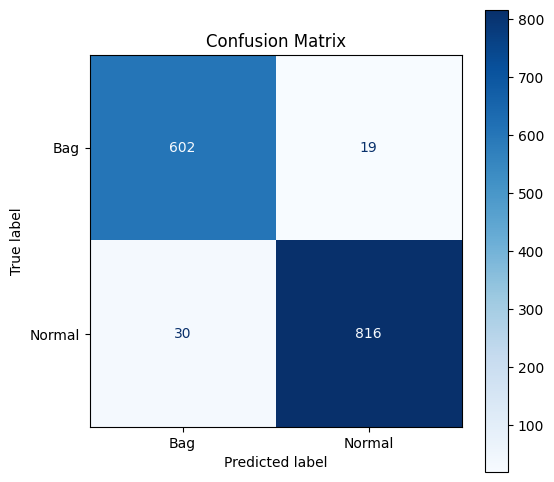


Classification Report:

              precision    recall  f1-score   support

         Bag       0.95      0.97      0.96       621
      Normal       0.98      0.96      0.97       846

    accuracy                           0.97      1467
   macro avg       0.96      0.97      0.97      1467
weighted avg       0.97      0.97      0.97      1467



In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.dataset.classes)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_test, target_names=train_data.dataset.classes))


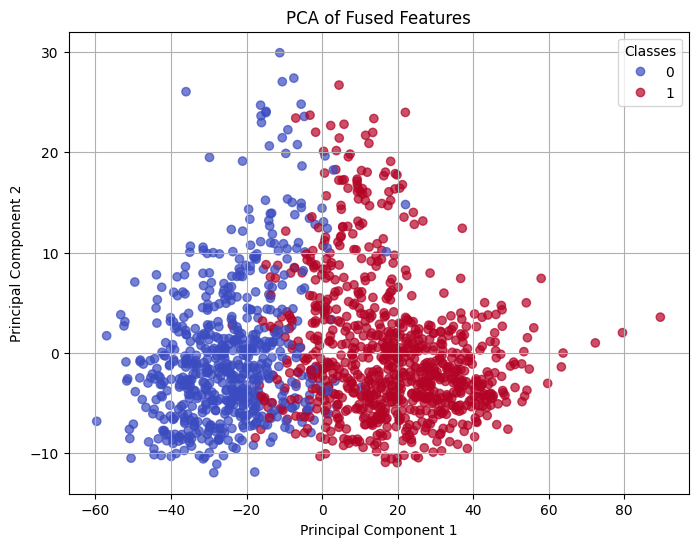

In [21]:
from sklearn.decomposition import PCA

# Reduce to 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test, cmap='coolwarm', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('PCA of Fused Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


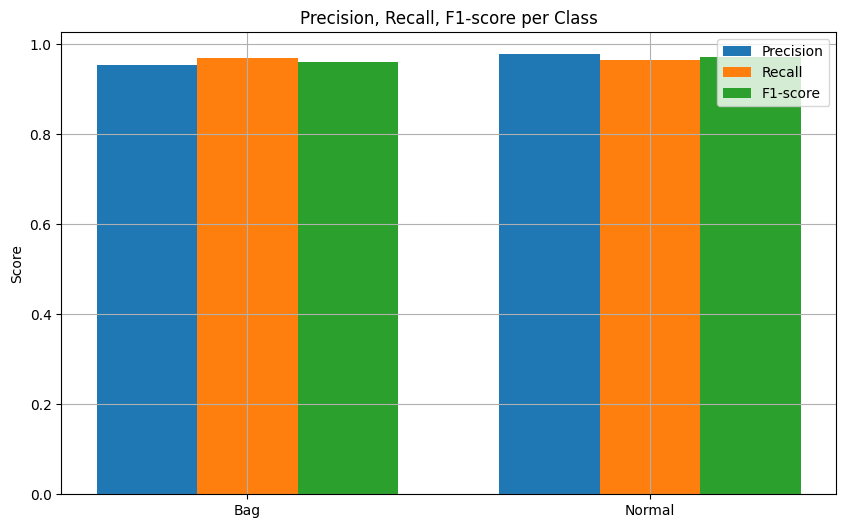

In [22]:
from sklearn.metrics import precision_recall_fscore_support

precisions, recalls, f1s, _ = precision_recall_fscore_support(y_test, y_pred_test)

x = range(len(train_data.dataset.classes))

plt.figure(figsize=(10,6))
plt.bar(x, precisions, width=0.25, label='Precision')
plt.bar([i+0.25 for i in x], recalls, width=0.25, label='Recall')
plt.bar([i+0.5 for i in x], f1s, width=0.25, label='F1-score')
plt.xticks([i+0.25 for i in x], train_data.dataset.classes)
plt.ylabel('Score')
plt.title('Precision, Recall, F1-score per Class')
plt.legend()
plt.grid(True)
plt.show()
